In [1]:
from datetime import date, datetime as dt
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy as sa
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker, aliased
from tqdm.notebook import tqdm, trange

from nea_schema.esi.uni import Jumps, Kills
from nea_schema.sde.map import Region, Constellation, System, Stargate
from nea_schema.sde.inv import Name
from config.config import sql_params
from tools import fourier, wave

sns.set()

In [2]:
target = 0.8
horizon = 14
alpha = 1 - ((1-target)**(1/horizon))

In [3]:
region_ids = [
    #10000032,
    #10000037,
    #10000064,
    10000068,
]

In [4]:
engine = create_engine('{engine}://{user}:{passwd}@{host}/{db}'.format(**sql_params))
session = sessionmaker(bind=engine)
conn = session()

DestStargate = aliased(Stargate)
query = conn.query(
    Stargate.stargate_id,
    Stargate.system_id,
    Stargate.dest_stargate_id,
    DestStargate.system_id.label('dest_system_id'),
).join(DestStargate, Stargate.dest_stargate_id == DestStargate.stargate_id)\
    .join(System, Stargate.system_id == System.system_id)\
    .join(Constellation, System.constellation_id == Constellation.constellation_id)\
    .filter(Constellation.region_id.in_(region_ids))
gate_data = pd.read_sql(query.statement, query.session.bind, index_col='stargate_id')

system_ids = gate_data['dest_system_id'].unique().tolist()

SystemName = aliased(Name)
ConstName = aliased(Name)
RegionName = aliased(Name)
query = conn.query(
    System.system_id,
    SystemName.item_name.label('system_name'),
    Constellation.constellation_id,
    ConstName.item_name.label('constellation_name'),
    Region.region_id,
    RegionName.item_name.label('region_name'),
    System.security,
    System.security_class,
    System.border,
    System.corridor,
    System.fringe,
    System.hub,
    System.international,
    System.regional,
).join(SystemName, System.system_id == SystemName.item_id)\
    .join(Constellation, System.constellation_id == Constellation.constellation_id)\
    .join(ConstName, Constellation.constellation_id == ConstName.item_id)\
    .join(Region, Constellation.region_id == Region.region_id)\
    .join(RegionName, Region.region_id == RegionName.item_id)\
    .filter(System.system_id.in_(system_ids))
system_data = pd.read_sql(query.statement, query.session.bind, index_col='system_id')

query = conn.query(
    Jumps.record_time,
    Jumps.system_id,
    Jumps.ship_jumps,
).filter(Jumps.record_time >= date(2020,1,1))\
    .filter(Jumps.system_id.in_(system_ids))
jumps_data = pd.read_sql(query.statement, query.session.bind)

conn.close()

In [5]:
system_data = system_data.reset_index().reset_index().set_index('system_id')

In [6]:
jumps_data['hour_of_day'] = jumps_data['record_time'].apply(lambda x: x.hour + (x.minute/60) + (x.second/60/60))
jumps_data['day_of_week'] = jumps_data['record_time'].apply(lambda x: x.weekday() + (x.hour/24) + (x.minute/24/60) + (x.second/24/60/60))
jumps_data['weights'] = (1-alpha) **(dt.utcnow() - jumps_data['record_time']).apply(lambda x: x.total_seconds()/60/60/24)

In [7]:
day_wave = fourier(jumps_data, 'ship_jumps', 'hour_of_day', 24, group_col='system_id', weights_col='weights')
week_wave = fourier(jumps_data, 'ship_jumps', 'day_of_week', 7, group_col='system_id', weights_col='weights')
waves = day_wave.drop(columns='offset').join(week_wave, lsuffix='_day', rsuffix='_week').loc[system_data.index,:]

In [8]:
buffer = []
for group, data in jumps_data.groupby('system_id'):
    data = data.copy()
    data['day_wave'] = wave(data['hour_of_day'], 24, *day_wave.loc[group])
    data['week_wave'] = wave(data['day_of_week'], 7, *week_wave.loc[group])
    data['full_wave'] = wave(
        data['hour_of_day'], 24, *day_wave.loc[group]
    ) + wave(
        data['day_of_week'], 7, *week_wave.loc[group]
    ) - week_wave.loc[group, 'offset']
    data['residual'] = data['ship_jumps'] - data['full_wave']
    buffer.append(data)
jumps_data = pd.concat(buffer, axis=0)

In [9]:
graph = ig.Graph()
graph.add_vertices(len(system_data))
edges = pd.concat([
    gate_data['system_id'].map(system_data['index']).rename('source'),
    gate_data['dest_system_id'].map(system_data['index']).rename('target'),
], axis=1).values.tolist()
graph.add_edges(edges)

In [10]:
for col in system_data.columns:
    graph.vs[col] = system_data[col].values
    
for col in waves.columns:
    graph.vs[col] = waves[col].values

In [38]:
cmap_region = {
    'Verge Vendor':'#1b9e77', # Green
    'Essence':'#d95f02', # Orange
    'Sinq Laison':'#7570b3', # Purple
    'Everyshore':'#e7298a', # Pink
}
vertex_labels = [
    '{}\n{}'.format(vertex['system_name'], str(np.round(vertex['phase_day'], 2)).replace('.',':'))
    for vertex in graph.vs
]

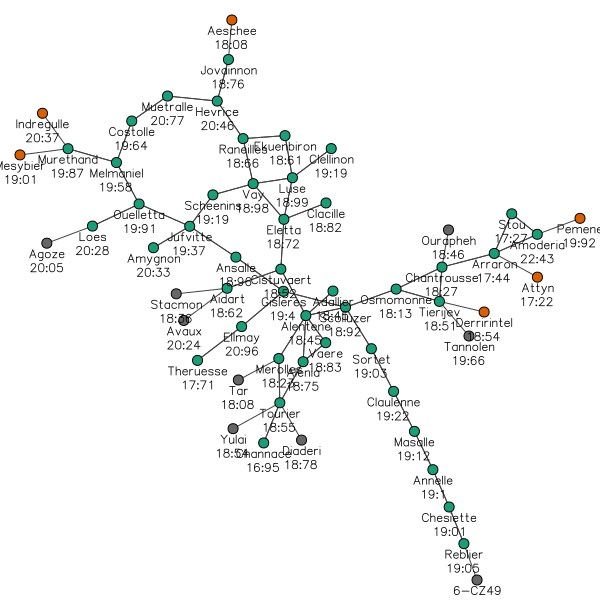

In [39]:
plot_params = dict(
    #layout=graph.layout('tree'),
    vertex_size=[10]*len(system_data),
    vertex_color=[cmap_region.get(vertex['region_name'], '#666666') for vertex in graph.vs],
    vertex_label=vertex_labels,
    vertex_label_dist=1,
    edge_curved=False,
)

ig.plot(graph, './plots/verge_vendor.png', **plot_params)